### Outlier Detection using autoencoders
#### Edgar Acuna
#### February 2022
#### Dataset: Diabetes amd Shuttle

In [45]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Diabetes

In [46]:
url= "https://academic.uprm.edu/eacuna/diabetes.dat"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
data = pd.read_table(url, names=names)
#Extracting class 1
data1=data[data['class']==1]
data1.head()
yd1=data1['class']

In [47]:
from sklearn.preprocessing import  StandardScaler
cols_to_norm = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age']
scaler = MinMaxScaler()
data1[cols_to_norm] = scaler.fit_transform(data1[cols_to_norm])

In [48]:
train_x = data1.drop(['class'], axis=1) #drop the class column
train_x.info()
train_x = train_x.values #transform to ndarray
train_x

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 1 to 767
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    500 non-null    float64
 1   plas    500 non-null    float64
 2   pres    500 non-null    float64
 3   skin    500 non-null    float64
 4   test    500 non-null    float64
 5   mass    500 non-null    float64
 6   pedi    500 non-null    float64
 7   age     500 non-null    float64
dtypes: float64(8)
memory usage: 35.2 KB


array([[0.07692308, 0.43147208, 0.54098361, ..., 0.46422339, 0.12127943,
        0.16666667],
       [0.07692308, 0.45177665, 0.54098361, ..., 0.4904014 , 0.03953798,
        0.        ],
       [0.38461538, 0.58883249, 0.60655738, ..., 0.44677138, 0.05464238,
        0.15      ],
       ...,
       [0.15384615, 0.61928934, 0.57377049, ..., 0.64223386, 0.11639271,
        0.1       ],
       [0.38461538, 0.6142132 , 0.59016393, ..., 0.45724258, 0.07418925,
        0.15      ],
       [0.07692308, 0.47208122, 0.57377049, ..., 0.53054101, 0.10528654,
        0.03333333]])

In [49]:
# No of Neurons in each Layer 
nb_epoch = 20
batch_size = 50
input_dim = train_x.shape[1] #num of columns, 8
encoding_dim = 4
hidden_dim = int(encoding_dim / 2) #i.e. 7
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 24        
Total params: 76
Trainable params: 76
Non-trainable params: 0
_________________________________________________________________


In [50]:
import datetime
autoencoder.compile(optimizer='adam', loss='mse' )

t_ini = datetime.datetime.now()
history = autoencoder.fit(train_x, train_x,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.1,
                        verbose=0
                        )

t_fin = datetime.datetime.now()
print('Time to run the model: {} Sec.'.format((t_fin - 
t_ini).total_seconds()))



df_history = pd.DataFrame(history.history) 

Time to run the model: 0.627143 Sec.


In [51]:
#Reconstruction
predictions = autoencoder.predict(train_x)
print(predictions)
#train_x.shape

[[0.28288624 0.40057632 0.56356597 ... 0.         0.2115675  0.        ]
 [0.2684534  0.389767   0.53485864 ... 0.         0.20650679 0.        ]
 [0.2509532  0.37650022 0.5001081  ... 0.         0.20016354 0.        ]
 ...
 [0.27583173 0.3953082  0.54952884 ... 0.         0.20911369 0.        ]
 [0.27256712 0.39286035 0.54303646 ... 0.         0.20796527 0.        ]
 [0.27793866 0.39688468 0.5537201  ... 0.         0.20985053 0.        ]]


In [52]:
mse = np.mean(np.power(train_x- predictions, 2), axis=1)

In [53]:
mse = np.mean(np.power(train_x- predictions, 2), axis=1)
df_error = pd.DataFrame({'reconstruction_error': mse}, index=yd1.index)
df_error.describe()

,reconstruction_error
count,500.000000
mean,0.072221
std,0.037325
min,0.011633
25%,0.044533
50%,0.063218
75%,0.088733
max,0.299699


In [54]:
y=df_error['reconstruction_error'].tolist()
x = df_error.index.tolist()

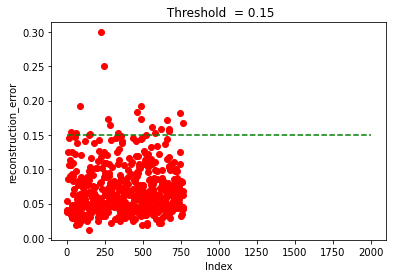

In [55]:
thresh=0.15
plt.plot(x, y, 'ro')
plt.ylabel('reconstruction_error')
plt.xlabel('Index')
plt.title(' Threshold  = ' +str(thresh))
plt.plot([0,2000],[thresh,thresh],"g--")

In [56]:
dfOutliers = df_error.index[df_error.reconstruction_error > .15].tolist()
len(dfOutliers)

21

In [57]:
print(dfOutliers)

[28, 58, 86, 153, 228, 247, 274, 286, 335, 459, 487, 489, 518, 558, 582, 622, 658, 673, 674, 744, 763]


In [58]:
#cleaning the data from outliers
data3=data.drop(dfOutliers,axis=0)

### Outlier effect on the LDA Classifier

In [59]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
#ldadis = LinearDiscriminantAnalysis().fit(Xd,yd)
#scores = cross_val_score(ldadis, Xd, yd, cv=10)
#print("Accuracy using LDA: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [60]:
#Accuracy after removing outliers
y=data3['class']
X=data3.iloc[:,0:8]
#Haciendo el analisis discriminante y calculando el porcentaje de precision
ldadis = LinearDiscriminantAnalysis().fit(X,y)
scores = cross_val_score(ldadis, X, y, cv=10)
scores
print("Accuracy using LDA after outlier removal: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy using LDA after outlier removal: 0.79 (+/- 0.09)


### Outlier effect on the KNN classifier

In [61]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
neigh = KNeighborsClassifier(n_neighbors=5)
#scores = cross_val_score(neigh, Xd, yd, cv=10)
#scores
#print("Accuracy using k=5 neighbors: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [62]:
#Accuracy after remoing outliers
y=data3['class']
X=data3.iloc[:,0:8]
y1=y.to_numpy()
X1=X.to_numpy()
neigh = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(neigh, X1, y1, cv=10)
scores
print("Accuracy using k=5 neighbors after outlier removal: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy using k=5 neighbors after outlier removal: 0.73 (+/- 0.09)


## Shuttle

In [63]:
url = "https://academic.uprm.edu/eacuna/shuttle.trn"
data = pd.read_table(url, header=None,delim_whitespace=True)
print(data)

        0   1    2  3   4   5   6   7   8  9
0      50  21   77  0  28   0  27  48  22  2
1      55   0   92  0   0  26  36  92  56  4
2      53   0   82  0  52  -5  29  30   2  1
3      37   0   76  0  28  18  40  48   8  1
4      37   0   79  0  34 -26  43  46   2  1
...    ..  ..  ... ..  ..  ..  ..  ..  .. ..
43495  46   5   78  0  46   5  32  32   0  1
43496  37   0   79 -1  10   3  43  69  26  1
43497  48   0   78  3  46   0  30  32   2  1
43498  41   0   79  0  38 -25  38  40   2  1
43499  40  -3  100  0  38   0  61  62   2  1

[43500 rows x 10 columns]


In [64]:
#Extracting class 1
y1=data.iloc[:,9]
X1=data[y1==1]
X1=X1.iloc[:,0:9]
X1.head()

,0,1,2,3,4,5,6,7,8
2,53,0,82,0,52,-5,29,30,2
3,37,0,76,0,28,18,40,48,8
4,37,0,79,0,34,-26,43,46,2
7,55,-1,95,-3,54,-4,40,41,2
9,37,0,101,-7,28,0,64,73,8


In [65]:
scaler = StandardScaler()
scaler.fit(X1)
Xdf1 = pd.DataFrame(scaler.transform(X1), index=X1.index)
train_x = Xdf1.values #transform to ndarray
train_x

array([[ 1.39510885,  0.01504652, -0.31306347, ..., -1.19279784,
        -0.9970992 , -0.29625408],
       [-1.07792269,  0.01504652, -1.00452981, ..., -0.0769073 ,
         0.16411275,  0.31802184],
       [-1.07792269,  0.01504652, -0.65879664, ...,  0.22742648,
         0.0350892 , -0.29625408],
       ...,
       [ 0.6222865 ,  0.01504652, -0.77404103, ..., -1.09135325,
        -0.86807565, -0.29625408],
       [-0.45966481,  0.01504652, -0.65879664, ..., -0.27979649,
        -0.35198145, -0.29625408],
       [-0.61422928, -0.09286072,  1.76133554, ...,  2.05342918,
         1.0672776 , -0.29625408]])

In [66]:
nb_epoch = 20
batch_size = 100
input_dim = train_x.shape[1] #num of columns, 8
encoding_dim = 4
hidden_dim = int(encoding_dim / 2) #i.e. 7
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 40        
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_19 (Dense)             (None, 9)                 27        
Total params: 83
Trainable params: 83
Non-trainable params: 0
_________________________________________________________________


In [67]:
import datetime
autoencoder.compile(optimizer='adam', loss='mse' )

t_ini = datetime.datetime.now()
history = autoencoder.fit(train_x, train_x,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.1,
                        verbose=0
                        )

t_fin = datetime.datetime.now()
print('Time to run the model: {} Sec.'.format((t_fin - 
t_ini).total_seconds()))



df_history = pd.DataFrame(history.history) 

Time to run the model: 3.153136 Sec.


In [68]:
#Reconstruction
predictions = autoencoder.predict(train_x)
#print(predictions)
train_x.shape

(34108, 9)

In [69]:
mse = np.mean(np.power(train_x- predictions, 2), axis=1)
print(len(mse))

34108


In [70]:
mse = np.mean(np.power(train_x- predictions, 2), axis=1)
df_error = pd.DataFrame({'reconstruction_error': mse}, index=X1.index)
df_error.describe()

,reconstruction_error
count,34108.000000
mean,0.696462
std,18.352966
min,0.016335
25%,0.125922
50%,0.260100
75%,0.453207
max,2357.955448


In [71]:
y=df_error['reconstruction_error'].tolist()
x = df_error.index.tolist()

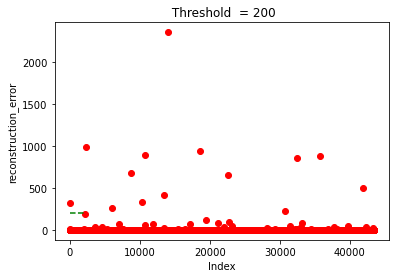

In [72]:
thresh=200
plt.plot(x, y, 'ro')
plt.ylabel('reconstruction_error')
plt.xlabel('Index')
plt.title(' Threshold  = ' +str(thresh))
plt.plot([0,2000],[thresh,thresh],"g--")

In [73]:
dfOutliers = df_error.index[df_error.reconstruction_error > 200].tolist()
print(dfOutliers)

[70, 2294, 6004, 8688, 10303, 10730, 13430, 14059, 18624, 22645, 30721, 32422, 35729, 41854]
